In [1]:
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

RANDOM_SEED = 42

# 1. Make a binary classification dataset with Scikit-Learn's `make_moons()` function.


* For consistency, the dataset should have 1000 samples and a `random_state=42`.

* Turn the data into PyTorch tensors.

* Split the data into training and test sets using `train_test_split with` 80% training and 20% testing.


In [2]:
# Create a dataset with Scikit-learn's make_moons()
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, random_state=42, noise=0.07)

In [3]:
# Turn data into a DataFrame
import pandas as pd
data = {"X1": X[:, 0],
        "X2": X[:, 1],
        "label": y}

df = pd.DataFrame(data)
df.head()

,X1,X2,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


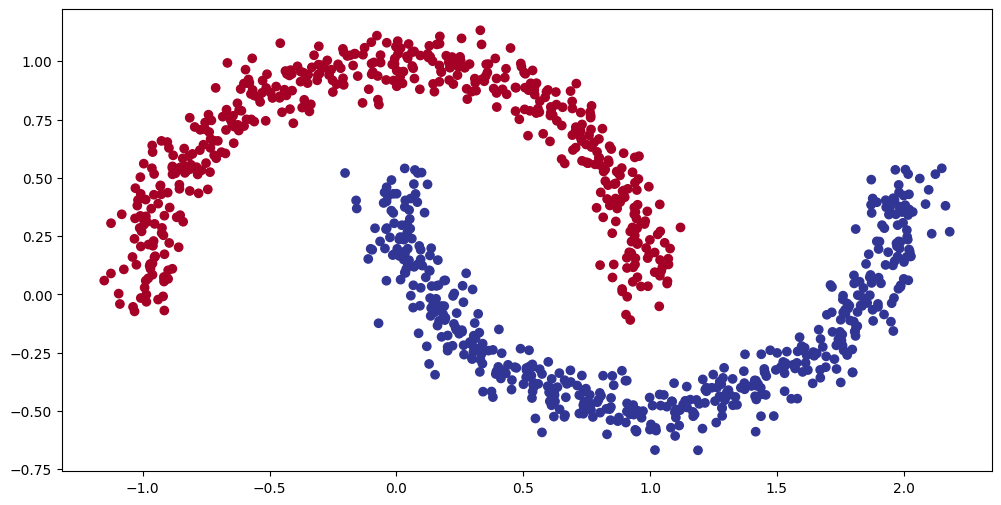

In [4]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(df["X1"], df["X2"], c=df["label"], cmap=plt.cm.RdYlBu)

In [5]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [6]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the moon data
class MoonModelV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model = MoonModelV0(input_features=2, output_features=1, hidden_units=10)
model.to(device)

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [7]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
LEARNING_RATE = 0.1
optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

* Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.

* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.

* Train the model for long enough for it to reach over 96% accuracy.

* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [8]:
# Put data to the target devic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [9]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model(X_train[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model(X_train)[:10]).squeeze())

# Prediction labels
print("Pred labels:")
print(torch.round(torch.sigmoid(model(X_train)[:10]).squeeze()))

Logits:
tensor([0.1607, 0.1546, 0.1362, 0.1611, 0.1775, 0.1625, 0.1530, 0.1580, 0.1592,
        0.1767], grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5401, 0.5386, 0.5340, 0.5402, 0.5443, 0.5405, 0.5382, 0.5394, 0.5397,
        0.5441], grad_fn=<SqueezeBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<RoundBackward0>)


In [10]:
!pip -q install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.5 MB/s eta 0:00:00


In [11]:
# Calculate the accuracy
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=2).to(device)
accuracy_fn

MulticlassAccuracy()

In [12]:
torch.manual_seed(RANDOM_SEED)

epochs = 1000

for epoch in range(epochs):
  ### Training
  model.train()

  # Forwards Pass
  y_logits = model(X_train).squeeze()
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  # Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred, y_train.int())

  # Zero the gradients
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Gradient descent
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    # Forward Pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
    test_acc = accuracy_fn(test_pred, y_test.int())

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f}% Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70 Acc: 0.51 | Test loss: 0.85% Test Acc: 0.46%
Epoch: 100 | Loss: 0.43 Acc: 0.81 | Test loss: 0.60% Test Acc: 0.83%
Epoch: 200 | Loss: 0.24 Acc: 0.89 | Test loss: 0.56% Test Acc: 0.91%
Epoch: 300 | Loss: 0.17 Acc: 0.93 | Test loss: 0.55% Test Acc: 0.94%
Epoch: 400 | Loss: 0.10 Acc: 0.97 | Test loss: 0.54% Test Acc: 0.97%
Epoch: 500 | Loss: 0.05 Acc: 0.99 | Test loss: 0.52% Test Acc: 0.99%
Epoch: 600 | Loss: 0.03 Acc: 1.00 | Test loss: 0.52% Test Acc: 0.99%
Epoch: 700 | Loss: 0.02 Acc: 1.00 | Test loss: 0.52% Test Acc: 0.99%
Epoch: 800 | Loss: 0.02 Acc: 1.00 | Test loss: 0.52% Test Acc: 0.99%
Epoch: 900 | Loss: 0.01 Acc: 1.00 | Test loss: 0.52% Test Acc: 1.00%


## 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [13]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


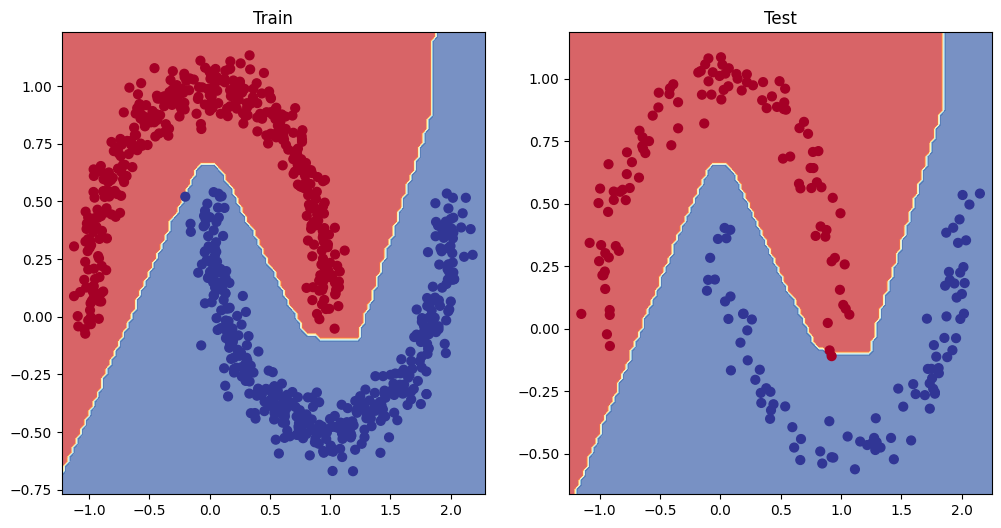

In [14]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)



## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

* Feel free to reference the ML cheatsheet website for the formula. : https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh

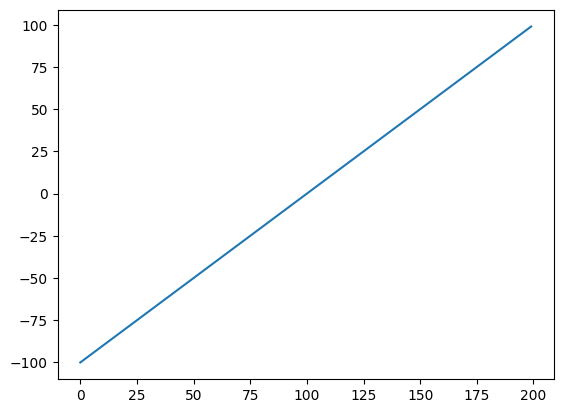

In [15]:
# Create a straight line tensor
line_tensor = torch.arange(-100, 100, 1)
plt.plot(line_tensor)

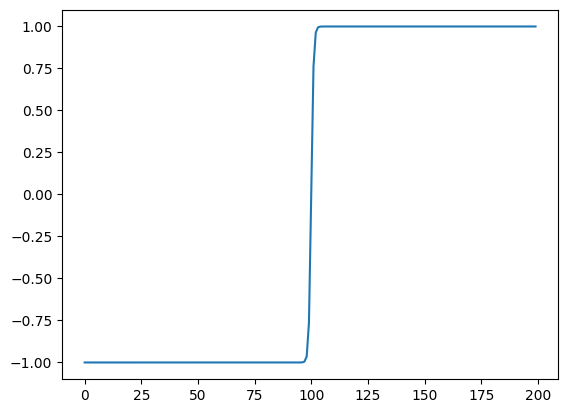

In [16]:
# Test torch.tanh() on the tensor and plot it
plt.plot(torch.tanh(line_tensor))

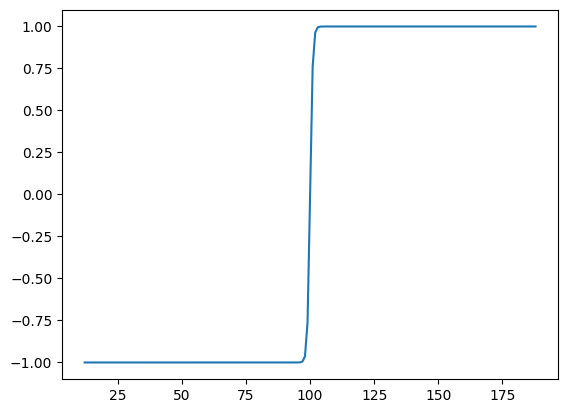

In [17]:
# Replicate torch.tanh() and plot it
def tanh(z):
  return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))


plt.plot(tanh(line_tensor))

## 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).


* Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.

* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).

* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).

*  Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.

* Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.


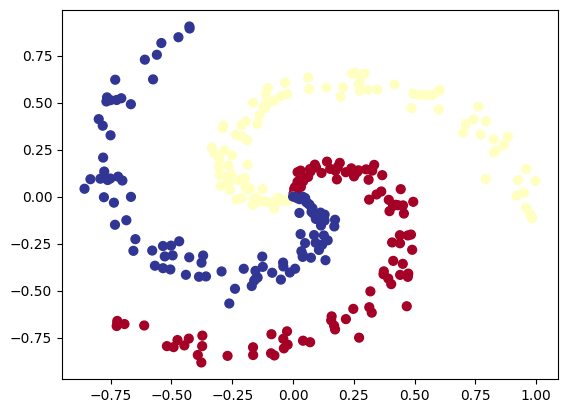

In [18]:
# Code for creating dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N = 100 # number of points per class
D = 2 # Dimensionality
K = 3 # Number of classes

X = np.zeros((N*K, D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
  ix = range(N*j, N*(j+1))
  r = np.linspace(0.0, 1, N) # radius
  t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j


# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [19]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [20]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [21]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


# Instantiate model and send it to device
spiral_model = SpiralModel(input_features=2,
                  output_features=4,
                  hidden_units=8).to(device)
spiral_model



SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [22]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
print(spiral_model(X_train)[:10])

print("Pred probs:")
print(torch.softmax(spiral_model(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(spiral_model(X_train)[:10], dim=1).argmax(dim=1))


Logits:
tensor([[ 0.2295, -0.3114,  0.0898, -0.0321],
        [ 0.2280, -0.3032,  0.0883, -0.0150],
        [ 0.1873, -0.2846,  0.0484, -0.0899],
        [ 0.2356, -0.3014,  0.0968, -0.0222],
        [ 0.2584, -0.2443,  0.1568,  0.0053],
        [ 0.0844, -0.3141, -0.1142, -0.2028],
        [ 0.2528, -0.2676,  0.1389, -0.0156],
        [ 0.2667, -0.2408,  0.1669, -0.0011],
        [ 0.2070, -0.3520,  0.0360, -0.0385],
        [ 0.1541, -0.2846,  0.0023, -0.1278]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3104, 0.1807, 0.2699, 0.2389],
        [0.3085, 0.1814, 0.2683, 0.2419],
        [0.3075, 0.1918, 0.2676, 0.2331],
        [0.3098, 0.1811, 0.2697, 0.2394],
        [0.3044, 0.1842, 0.2750, 0.2364],
        [0.3085, 0.2071, 0.2529, 0.2315],
        [0.3076, 0.1828, 0.2745, 0.2352],
        [0.3056, 0.1840, 0.2766, 0.2338],
        [0.3128, 0.1789, 0.2636, 0.2447],
        [0.3069, 0.1979, 0.2637, 0.2315]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01
optimizer = torch.optim.Adam(params=spiral_model.parameters(), lr=LEARNING_RATE)



In [24]:
epochs = 1000

# Build a training loop for the model

# Loop over data
for epoch in range(epochs):

  ## Training
  spiral_model.train()
  # 1. Forward pass
  y_logits = spiral_model(X_train)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_pred = y_pred_probs.argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = spiral_model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)
  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} Acc: {acc:.2f}% | Test loss: {test_loss:.4f} Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.3887 Acc: 0.35% | Test loss: 1.3677 Test acc: 0.27%
Epoch: 100 | Loss: 0.5211 Acc: 0.74% | Test loss: 0.6154 Test acc: 0.65%
Epoch: 200 | Loss: 0.2060 Acc: 0.93% | Test loss: 0.2721 Test acc: 0.87%
Epoch: 300 | Loss: 0.0859 Acc: 0.98% | Test loss: 0.1237 Test acc: 0.97%
Epoch: 400 | Loss: 0.0474 Acc: 0.99% | Test loss: 0.0623 Test acc: 1.00%
Epoch: 500 | Loss: 0.0336 Acc: 0.99% | Test loss: 0.0436 Test acc: 1.00%
Epoch: 600 | Loss: 0.0269 Acc: 0.99% | Test loss: 0.0329 Test acc: 1.00%
Epoch: 700 | Loss: 0.0235 Acc: 0.99% | Test loss: 0.0260 Test acc: 1.00%
Epoch: 800 | Loss: 0.0214 Acc: 0.99% | Test loss: 0.0211 Test acc: 1.00%
Epoch: 900 | Loss: 0.0199 Acc: 0.99% | Test loss: 0.0174 Test acc: 1.00%


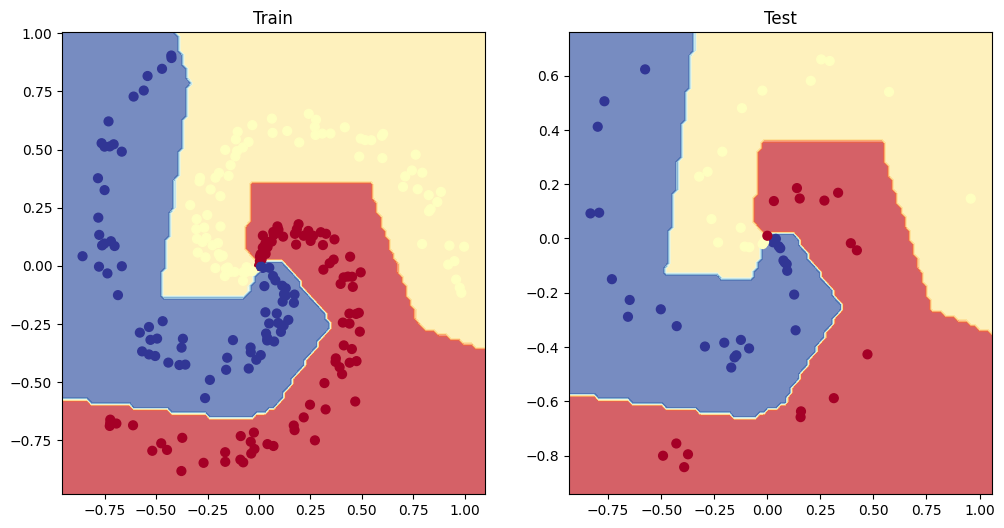

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(spiral_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(spiral_model, X_test, y_test)